In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

## NAICS Embedding K-Means - Randomized Hidden Layer Only (A01)
Do some k means groups, and analyze some of the outcomes

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib, pickle

In [3]:
import matplotlib.pyplot as plt
from sba_nn.sba_nn import sbnn_plot, sbnn_embed
import matplotlib.ticker as ticker
import textwrap

In [4]:
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
import seaborn as sns

In [6]:
sbnn_plot.plot_defaults()

## Import Data

##### NAICS info (predictors, target levels)

In [7]:
naics_info = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_naics_info.parquet'))

In [8]:
# Truncate target rates below a threshold
naics_info['target_thresh'] = naics_info['target'].where(naics_info['count'] >= 100, np.nan)

In [9]:
naics_info_pred = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_naics_info_predictors.parquet'))

In [10]:
naics_features = ['NAICS_orig', 'NAICS_4_orig', 'NAICS_3_orig', 'NAICS_sector_orig']

##### NAICS descriptions (all levels)
Add in year min/max info

In [11]:
naics_desc = pd.read_parquet('./naics/naics_desc_long_all_labels.parquet') \
    .merge(pd.read_parquet('./naics/naics_desc_wide.parquet')[['NAICS', 'year_min', 'year_max']],
           on='NAICS')

In [12]:
naics_desc.sample(3)

,NAICS,NAICS_desc,NAICS_sector_desc,NAICS_3_desc,NAICS_4_desc,NAICS_5_desc,year_min,year_max
1014,541320,Landscape Architectural Services,"Professional, Scientific, and Technical Services","Professional, Scientific, and Technical Services","Architectural, Engineering, and Related Services",Landscape Architectural Services,2002,2017
411,331110,Iron and Steel Mills and Ferroalloy Manufactur...,Manufacturing,Primary Metal Manufacturing,Iron and Steel Mills and Ferroalloy Manufacturing,Iron and Steel Mills and Ferroalloy Manufacturing,2012,2017
917,517211,Paging,Information,Telecommunications,Wireless Telecommunications Carriers (except S...,Wireless Telecommunications Carriers (except S...,2002,2002


In [13]:
naics_desc.shape

(1283, 8)

#####  Higher-level NAICS maps

In [14]:
naics_map_4 = pd.read_parquet('./naics/naics4_long_all_labels.parquet')
naics_map_3 = pd.read_parquet('./naics/naics3_long_all_labels.parquet')
naics_map_2 = pd.read_parquet('./naics/naics2_long_all_labels.parquet')

##### Embeddings

In [15]:
emb_all = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embeddings.parquet'))
emb_all = emb_all[emb_all['model'] == 'A01'] \
    .sort_values('NAICS_orig') \
    .reset_index(drop=True)

In [16]:
emb_all.head(2)

,NAICS_orig,emb_00,emb_01,emb_02,emb_03,emb_04,emb_05,emb_06,emb_07,dset_naics_holdout,NAICS_4_orig,NAICS_3_orig,NAICS_sector_orig,model
0,111110,0.829431,-0.429467,-0.846687,-0.688373,0.833410,0.827503,-0.919467,0.813810,0.0,1111,111,11,A01
1,111120,0.230878,-0.260833,-0.291354,-0.539546,0.470609,0.598844,-0.677097,0.253074,0.0,1111,111,11,A01


In [17]:
emb_features = [c for c in emb_all if c.startswith('emb_')]
print(emb_features)

['emb_00', 'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07']


##### TSNE

In [18]:
tsne_df = pd.read_parquet(Path(setup.temp_path).joinpath('A10_DATA_embed_tsne.parquet'))
tsne_df = tsne_df[tsne_df['model'] == 'A01'] \
    .sort_values('NAICS_orig') \
    .reset_index(drop=True) \
    .merge(naics_info_pred, on='NAICS_orig') \
    .merge(emb_all[['NAICS_orig'] + emb_features], on='NAICS_orig', how='left')

##### Features

In [19]:
with open(Path(setup.parent_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [20]:
# List numeric features features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [21]:
features_orig = [c + '_orig' for c in features_numeric if c + '_orig' in naics_info_pred.columns]
print(features_orig)

['NoEmp_orig', 'CreateJob_orig', 'LowDoc_orig', 'DisbursementGross_orig', 'new_business_orig', 'urban_flag_orig', 'franchise_flag_orig']


In [22]:
tsne_df['sector_codes'] = tsne_df['NAICS_sector_orig'].cat.codes

In [23]:
# Dummy feature to suppress holdout plot
tsne_df['hd'] = 0 

<Axes: title={'center': 'TSNE by sector_codes'}, xlabel='$X_1$', ylabel='$X_2$'>

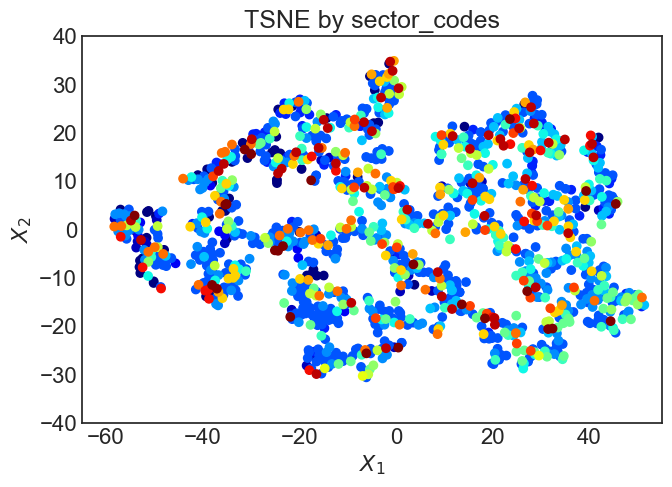

In [24]:
sbnn_embed.emb_color_plot(tsne_df, 'sector_codes', 'hd',
                          cmap=plt.get_cmap('jet'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                          show_colorbar=False,
                         outfile_prefix = 'A12_PLOT_emb_naics')

<Axes: title={'center': 'TSNE by target_thresh'}, xlabel='$X_1$', ylabel='$X_2$'>

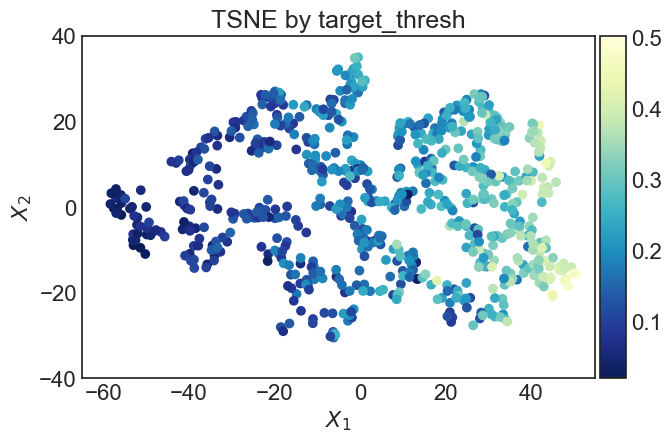

In [25]:
sbnn_embed.emb_color_plot(tsne_df, 'target_thresh', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A12_PLOT_emb_menx')

In [26]:
naics_silhouette = silhouette_score(emb_all[emb_features], 
                                        emb_all['NAICS_sector_orig'])
naics_silhouette_values  = silhouette_samples(emb_all[emb_features],
                                                 emb_all['NAICS_sector_orig'])

In [27]:
naics_silhouette

-0.29491758

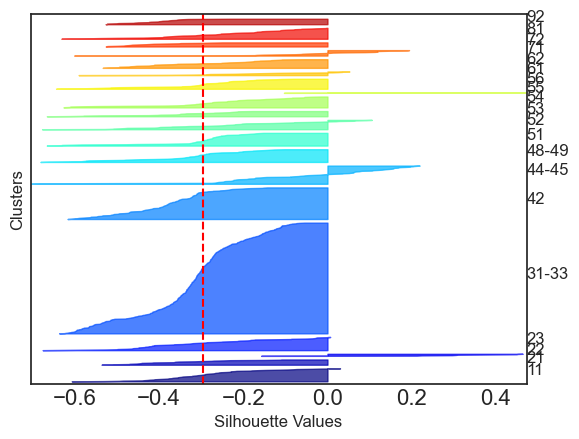

In [28]:
sbnn_embed.plot_silhouette(naics_silhouette_values, emb_all['NAICS_sector_orig'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('A12_PLOT_silhouette_base_naics_all.png'),
                 bbox_inches='tight') 

## Some feature Plots

In [29]:
tsne_df.columns

Index(['model', 'NAICS_orig', 'tsne_0', 'tsne_1', 'NAICS_sector_orig',
       'target_thresh', 'count', 'dset_naics_holdout', 'NoEmp', 'CreateJob',
       'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag',
       'franchise_flag', 'missingindicator_LowDoc',
       'missingindicator_new_business', 'missingindicator_urban_flag',
       'NoEmp_orig', 'CreateJob_orig', 'LowDoc_orig', 'DisbursementGross_orig',
       'new_business_orig', 'urban_flag_orig', 'franchise_flag_orig', 'emb_00',
       'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07',
       'sector_codes', 'hd'],
      dtype='object')

<Axes: title={'center': 'TSNE by DisbursementGross'}, xlabel='$X_1$', ylabel='$X_2$'>

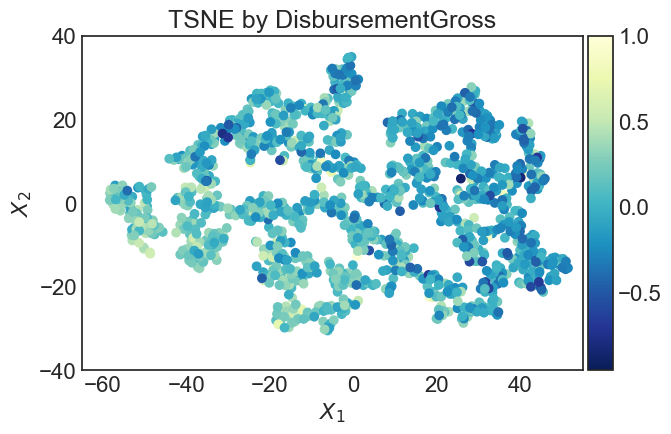

In [30]:
sbnn_embed.emb_color_plot(tsne_df, 'DisbursementGross', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=None)

<Axes: title={'center': 'TSNE by count'}, xlabel='$X_1$', ylabel='$X_2$'>

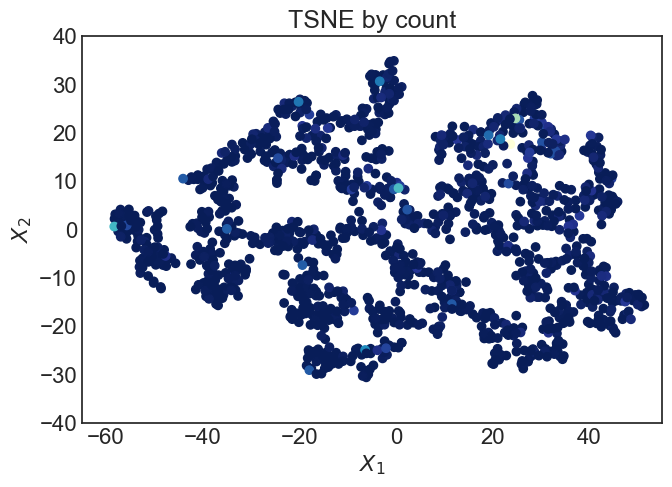

In [31]:
sbnn_embed.emb_color_plot(tsne_df, 'count', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          log_scale=True, show_colorbar=False,
                         outfile_folder=None)

<Axes: title={'center': 'TSNE by CreateJob'}, xlabel='$X_1$', ylabel='$X_2$'>

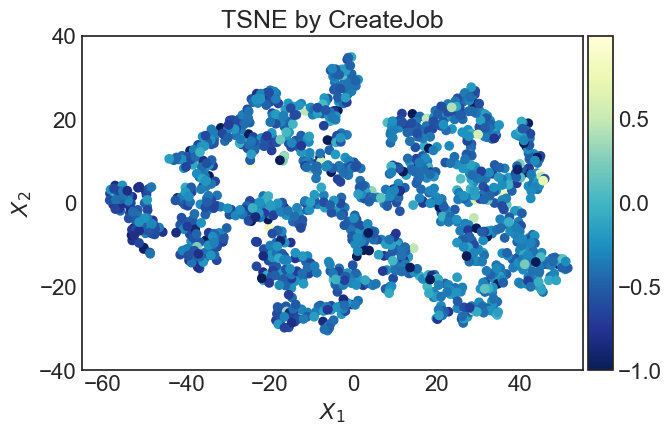

In [32]:
sbnn_embed.emb_color_plot(tsne_df, 'CreateJob', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          #log_scale=True, show_colorbar=False,
                         outfile_folder=None)

<Axes: title={'center': 'TSNE by new_business'}, xlabel='$X_1$', ylabel='$X_2$'>

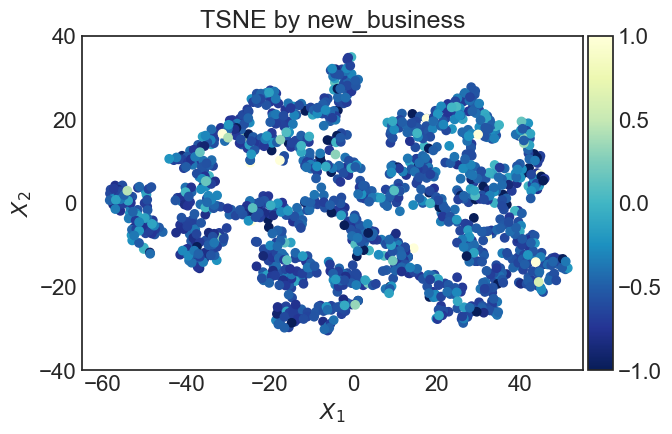

In [33]:
sbnn_embed.emb_color_plot(tsne_df, 'new_business', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                          #log_scale=True, show_colorbar=False,
                         outfile_folder=None)

<Axes: title={'center': 'TSNE by NoEmp'}, xlabel='$X_1$', ylabel='$X_2$'>

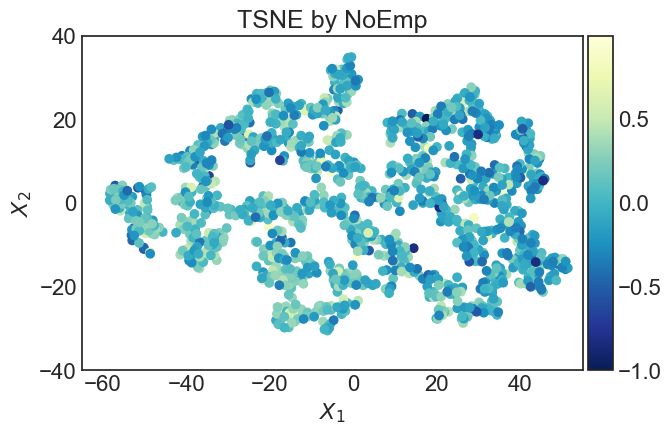

In [34]:
sbnn_embed.emb_color_plot(tsne_df, 'NoEmp', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A12_PLOT_emb_by_NoEmp')

<Axes: title={'center': 'TSNE by missingindicator_urban_flag'}, xlabel='$X_1$', ylabel='$X_2$'>

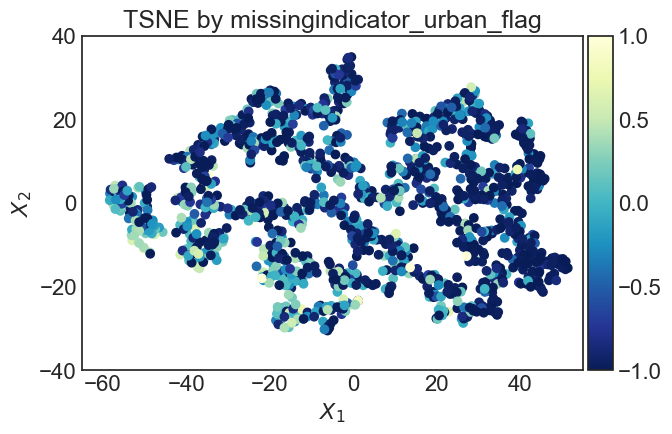

In [35]:
sbnn_embed.emb_color_plot(tsne_df, 'missingindicator_urban_flag', 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40])

## Embeddings
How do they align with the TSNE representation

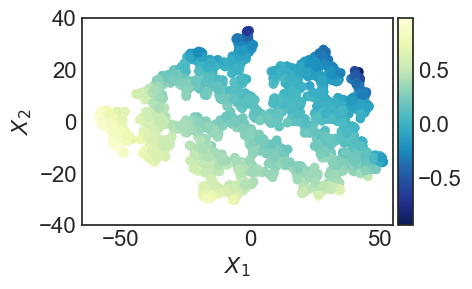

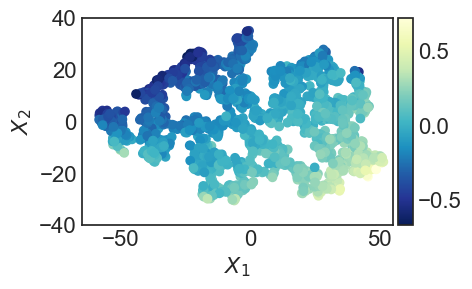

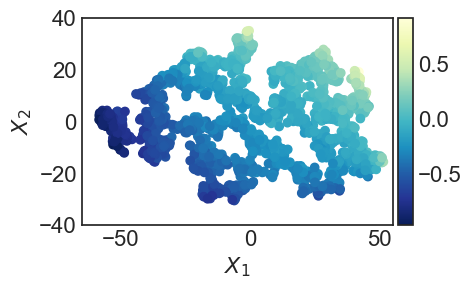

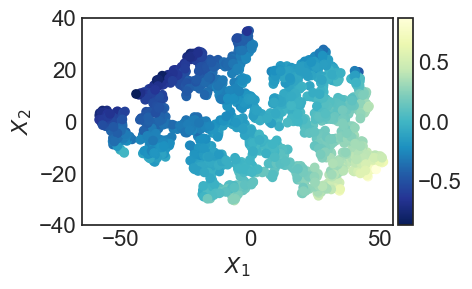

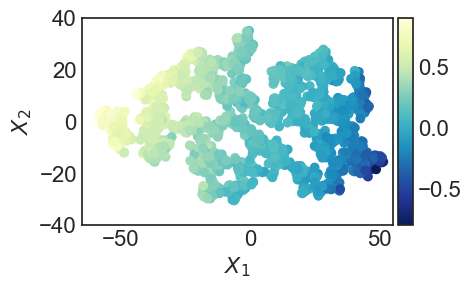

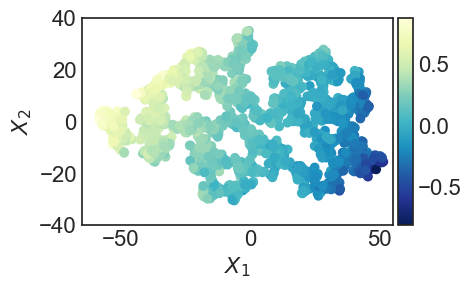

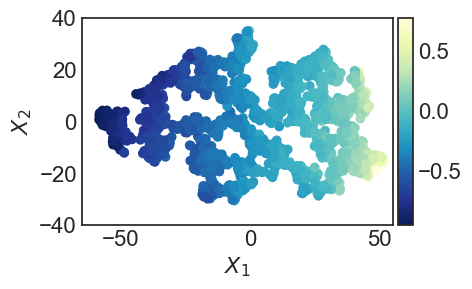

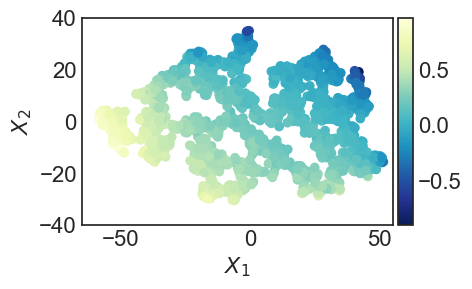

In [36]:
for emb_f in emb_features:
    sbnn_embed.emb_color_plot(tsne_df, emb_f, 'hd',
                          cmap=plt.get_cmap('YlGnBu_r'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                         outfile_prefix = 'A12_PLOT_' + emb_f,
                             title_str='', title_str_2 = None,
                             figsize = (5, 5))

## K Means Loop

In [37]:
range_n_clusters = np.arange(2, 25)
all_silhouette_summary = pd.DataFrame()
all_cluster_labels = pd.DataFrame()
all_cluster_centers = pd.DataFrame()
all_silhouette_values = pd.DataFrame()

for n_clusters in range_n_clusters:
    
    # Get the kmeans information
    cluster_labels, cluster_centers, silhouette_avg, sample_silhouette_values = \
        sbnn_embed.get_clusters_silhouettes(emb_all[emb_features], n_clusters)
        
    # Save silhouette summary
    all_silhouette_summary = pd.concat([all_silhouette_summary, 
                                        pd.DataFrame({'n_clusters': [n_clusters],
                                                      'silhouette_avg':[silhouette_avg]})])
    
    # Save silhouette values
    sample_silhouette_df = pd.DataFrame(sample_silhouette_values, columns=['value'],
                                       index = emb_all.index)
    sample_silhouette_df['n_clusters'] = n_clusters
    sample_silhouette_df.set_index('n_clusters', append=True,  inplace=True)
    all_silhouette_values = pd.concat([all_silhouette_values, sample_silhouette_df])
    
    # Save cluster labels
    cluster_df = pd.DataFrame(cluster_labels, columns=['label'], index=emb_all.index)
    cluster_df['n_clusters'] = n_clusters
    cluster_df.set_index('n_clusters', append=True,  inplace=True)
    all_cluster_labels = pd.concat([all_cluster_labels, cluster_df])
    
    # Save cluster centers
    cluster_centers_df = pd.DataFrame(cluster_centers)
    cluster_centers_df['n_clusters'] = n_clusters
    cluster_centers_df.set_index('n_clusters', append=True, inplace=True)
    all_cluster_centers = pd.concat([all_cluster_centers, cluster_centers_df])

In [38]:
all_silhouette_values.reset_index(level=1, inplace=True)
all_cluster_labels.reset_index(level=1, inplace=True)
all_cluster_centers.reset_index(level=1, inplace=True)

In [39]:
all_silhouette_values.to_parquet(Path(setup.temp_path).joinpath('A12_DATA_loop_silhouette_values.parquet'))
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('A12_DATA_loop_silhouette_summary.csv'))

In [40]:
all_cluster_labels.to_parquet(Path(setup.temp_path) \
                              .joinpath('A12_DATA_loop_cluster_labels.parquet'))
all_cluster_centers.columns = [str(c) for c in all_cluster_centers.columns]
all_cluster_centers.to_parquet(Path(setup.temp_path) \
                               .joinpath('A12_DATA_loop_cluster_centers.parquet'))

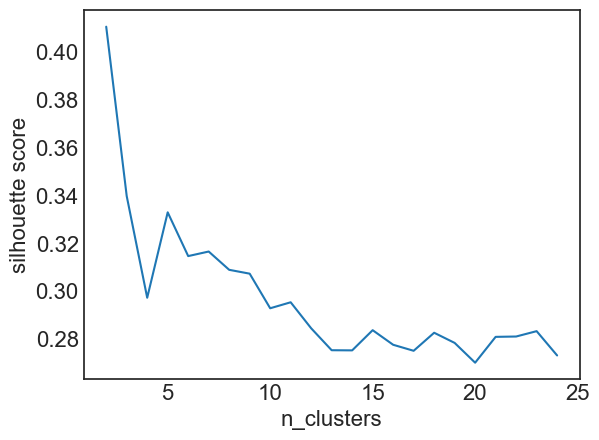

In [41]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
#plt.ylim(bottom=0)
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A12_PLOT_loop_silhouette_summary.png'),
                 bbox_inches='tight') 
all_silhouette_summary \
    .to_csv(Path(setup.temp_path).joinpath('A12_REPORT_loop_silhouette_summary.csv'))

In [42]:
best_clus = all_silhouette_summary.sort_values('silhouette_avg', ascending=False)['n_clusters'].iloc[0]
best_clus

2

## Function to get plots for k, also score

In [43]:
def clus_plots(k=best_clus,
               outfile_folder=Path(setup.temp_path),
               outfile_prefix = 'A12_PLOT_kmeans'):
    vals = all_silhouette_values[all_silhouette_values['n_clusters'] == k] \
        .drop(columns='n_clusters')
    labs= all_cluster_labels[all_cluster_labels['n_clusters'] == k] \
         .drop(columns='n_clusters') 
    
    sbnn_embed.plot_silhouette(vals.to_numpy(), labs.to_numpy(),
                        cmap = plt.get_cmap('jet'))
    plt.show()
    if outfile_folder is not None:        
        plt.gcf().savefig(Path(setup.temp_path) \
                              .joinpath(outfile_prefix + f'_{int(k):03d}_silh.png'),
                          bbox_inches='tight') 
    print(all_silhouette_summary[all_silhouette_summary['n_clusters'] == k])
    tsne_df[f'cluster_{k:03d}'] = labs['label']
               
    sbnn_embed.emb_color_plot(tsne_df, f'cluster_{k:03d}', 'hd',
                          cmap=plt.get_cmap('jet'), alpha = 1,
                         xlim=[-65,55], ylim=[-40, 40],
                         outfile_folder=Path(setup.temp_path),
                          show_colorbar=False,
                         outfile_prefix = outfile_prefix + f'_{int(k):03d}_emb.png')
    

## Best k Plots

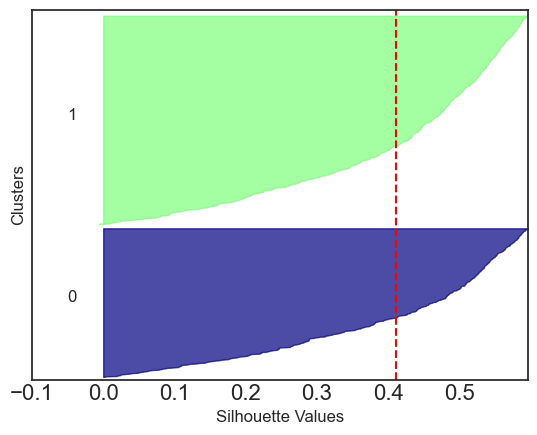

   n_clusters  silhouette_avg
0           2        0.410436


<Figure size 640x480 with 0 Axes>

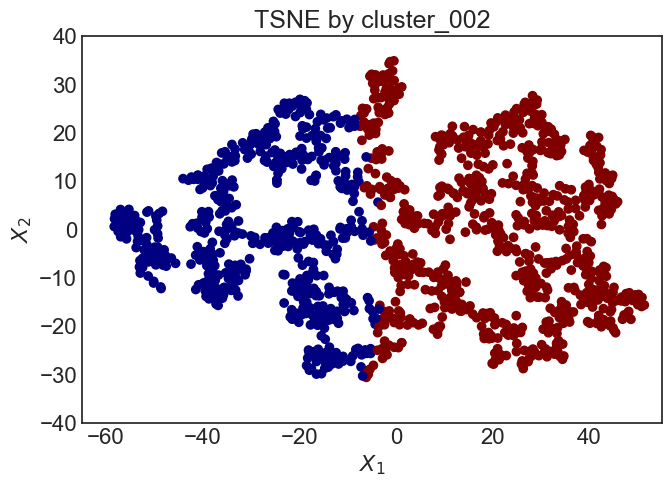

In [44]:
clus_plots()

## k=3 plots

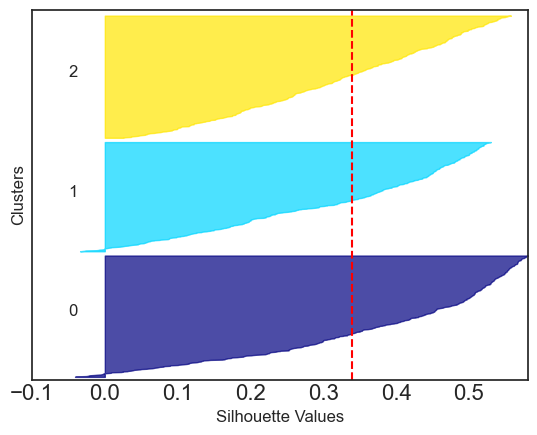

   n_clusters  silhouette_avg
0           3         0.33975


<Figure size 640x480 with 0 Axes>

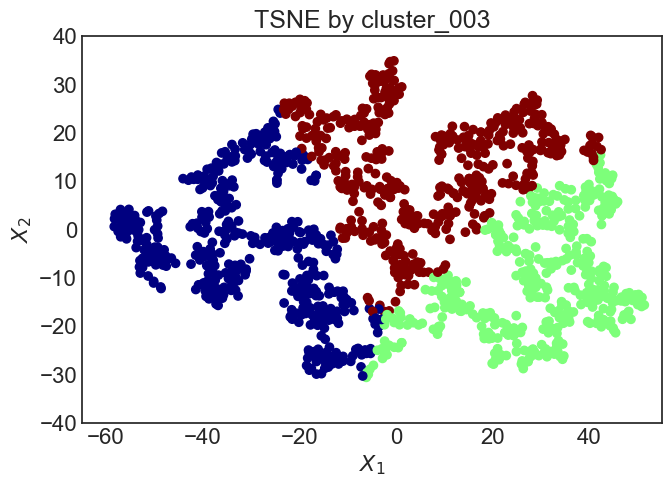

In [45]:
clus_plots(3)

## k=4 Plots

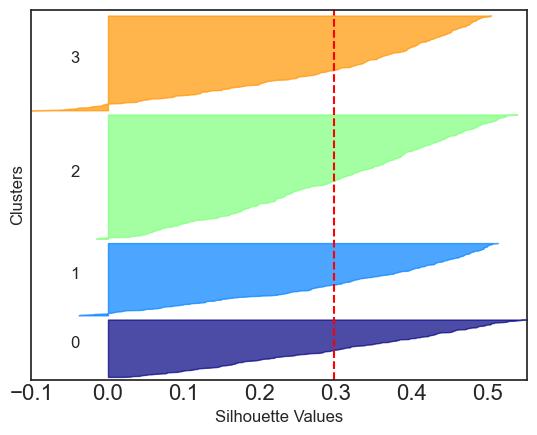

   n_clusters  silhouette_avg
0           4        0.297314


<Figure size 640x480 with 0 Axes>

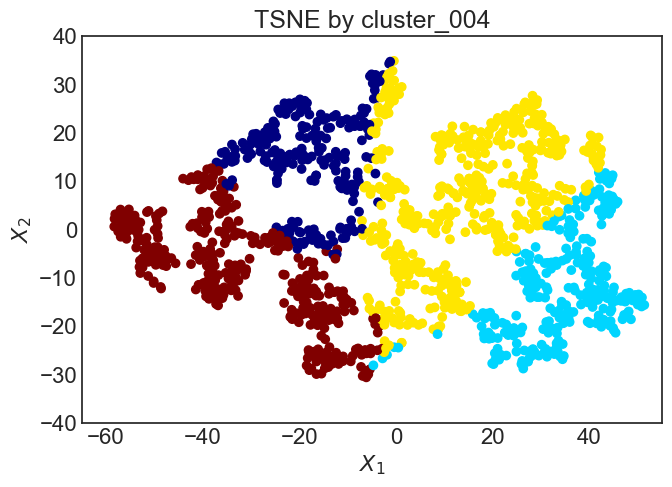

In [46]:
clus_plots(4)

## k=5 Plots

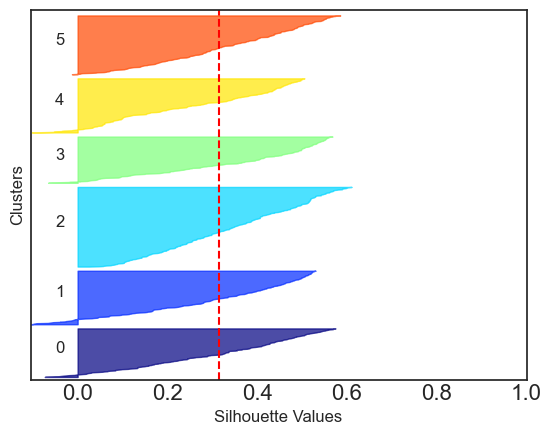

   n_clusters  silhouette_avg
0           6        0.314702


<Figure size 640x480 with 0 Axes>

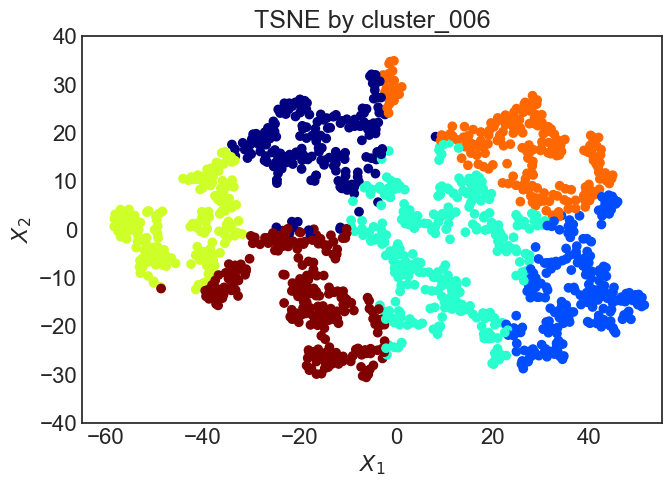

In [47]:
clus_plots(6)

## k=3 Feature Info

In [48]:
tsne_df.columns

Index(['model', 'NAICS_orig', 'tsne_0', 'tsne_1', 'NAICS_sector_orig',
       'target_thresh', 'count', 'dset_naics_holdout', 'NoEmp', 'CreateJob',
       'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag',
       'franchise_flag', 'missingindicator_LowDoc',
       'missingindicator_new_business', 'missingindicator_urban_flag',
       'NoEmp_orig', 'CreateJob_orig', 'LowDoc_orig', 'DisbursementGross_orig',
       'new_business_orig', 'urban_flag_orig', 'franchise_flag_orig', 'emb_00',
       'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07',
       'sector_codes', 'hd', 'cluster_002', 'cluster_003', 'cluster_004',
       'cluster_006'],
      dtype='object')

In [49]:
tsne_info = tsne_df.groupby('cluster_003')[['tsne_0', 'tsne_1']] \
    .agg(['mean', 'median', 'std'])
tsne_info.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_tsne_values.csv'))
tsne_info

tsne_0                           tsne_1                      
                  mean     median        std       mean     median        std
cluster_003                                                                  
0           -30.096771 -29.857883  14.065403  -3.945129  -3.541736  12.572023
1            28.462503  30.670124  13.667356 -10.831239 -13.046620  10.962047
2             6.438329   3.075590  15.740447  12.840270  15.139124  11.036246

In [50]:
thresh_grp = tsne_df.groupby('cluster_003')[['target_thresh', 'count', 'dset_naics_holdout']] \
    .agg(['mean', 'median', 'std'])
thresh_grp.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_overview.csv'))
thresh_grp

target_thresh                           count                      \
                     mean    median       std        mean median          std   
cluster_003                                                                     
0                0.092235  0.088908  0.039641  344.711752   79.0  1144.709943   
1                0.277049  0.282208  0.093066  407.110837  130.0   766.809488   
2                0.200239  0.198777  0.071272  825.436123  202.5  2137.938320   

            dset_naics_holdout                   
                          mean median       std  
cluster_003                                      
0                     0.044346    0.0  0.206091  
1                     0.108374    0.0  0.311236  
2                     0.147577    0.0  0.355072

##### Set Cluster Labels

In [51]:
clus_vals = thresh_grp[('target_thresh', 'mean')].sort_values()
clus_vals['labels'] = pd.Series(['low', 'med', 'high'], index=clus_vals.index)
clus_vals['labels'].to_dict()

{0: 'low', 2: 'med', 1: 'high'}

In [52]:
cluster_labels= {k:f'{v} ({k})' for k, v in clus_vals['labels'].to_dict().items()}

In [53]:
cluster_labels

{0: 'low (0)', 2: 'med (2)', 1: 'high (1)'}

In [54]:
with open(Path(setup.temp_path).joinpath('A12_DATA_cluster_labels.pkl'), 'wb') as fout:
    pickle.dump(cluster_labels, fout)

In [55]:
trans_feat_info = tsne_df.groupby('cluster_003')[features_numeric] \
    .agg(['mean', 'std', 'median']).unstack().unstack(level=1)
trans_feat_info.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_features_trans.csv'))

In [56]:
raw_feat_info = tsne_df.groupby('cluster_003')[features_orig] \
    .agg(['mean', 'std', 'median']).unstack().unstack(level=1)
raw_feat_info.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_features_raw.csv'))
raw_feat_info

mean            std  \
                       cluster_003                                 
NoEmp_orig             0                14.506048      11.711752   
                       1                12.993463      14.626739   
                       2                13.204599      10.874780   
CreateJob_orig         0                 2.457699       2.375442   
                       1                 2.570937       3.294081   
                       2                 2.382494       1.877865   
LowDoc_orig            0                 0.114581       0.116777   
                       1                 0.072413       0.103086   
                       2                 0.092006       0.084229   
DisbursementGross_orig 0            283492.258209  131542.911302   
                       1            246464.151202  420295.205349   
                       2            217939.636202  130309.333314   
new_business_orig      0                 0.235329       0.137608   
                       1                 0.239588       0.144267   
                       2                 0.249254       0.128588   
urban_flag_orig        0                 0.743694       0.198613   
                       1                 0.834231       0.139606   
                       2                 0.785804       0.163334   
franchise_flag_orig    0                 0.013125       0.059968   
                       1                 0.017193       0.046179   
                       2                 0.028893       0.070643   

                                           median  
                       cluster_003                 
NoEmp_orig             0                12.750000  
                       1                 8.605439  
                       2                10.004372  
CreateJob_orig         0                 1.986667  
                       1                 1.806643  
                       2                 1.909804  
LowDoc_orig            0                 0.090455  
                       1                 0.043521  
                       2                 0.076557  
DisbursementGross_orig 0            277639.625000  
                       1            189528.611386  
                       2            191987.374134  
new_business_orig      0                 0.212598  
                       1                 0.218974  
                       2                 0.230684  
urban_flag_orig        0                 0.797753  
                       1                 0.861683  
                       2                 0.826009  
franchise_flag_orig    0                 0.000000  
                       1                 0.000000  
                       2                 0.003534

In [57]:
# Loosely based on
# https://stackoverflow.com/questions/48307663/getting-weighted-average-and-standard-deviation-on-several-columns-in-pandas
def weighted_average_std(grp):
    tmp = grp.select_dtypes(include=[np.number])
    weights = tmp['count']
    values = tmp.drop(['count', 'cluster_003'], axis=1)
    average = values.mul(weights, axis=0).sum(axis=0) / \
        weights.sum()
    variance = ((values - average)**2).mul(weights, axis=0).sum(axis=0) / \
        weights.sum()
    std = np.sqrt(variance)
    return pd.DataFrame({'mean':average, 'std':std}, index=values.columns)

In [58]:
grouped = tsne_df[features_orig + ['target_thresh', 'cluster_003', 'count']].groupby('cluster_003')
wt_data = pd.concat([weighted_average_std(g) for n,g in grouped],
                    keys = [n for n,g in grouped]) \
    .reset_index() \
    .rename(columns={'level_0':'cluster_003', 'level_1':'feature'}) \
    .sort_values(['feature', 'cluster_003'])
wt_data.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_features_wt_mean_raw.csv'),
              index=False)
wt_data

,cluster_003,feature,mean,std
1,0,CreateJob_orig,2.067340,1.327189
9,1,CreateJob_orig,2.076769,1.307223
17,2,CreateJob_orig,2.268244,1.546322
3,0,DisbursementGross_orig,275710.784652,146481.804159
11,1,DisbursementGross_orig,180078.192744,107927.644662
19,2,DisbursementGross_orig,166930.620470,65867.619081
2,0,LowDoc_orig,0.095437,0.054218
10,1,LowDoc_orig,0.060710,0.059223
18,2,LowDoc_orig,0.114224,0.063105
0,0,NoEmp_orig,11.037681,7.590260


In [59]:
grouped = tsne_df[features_numeric + ['cluster_003', 'count']].groupby('cluster_003')
wt_data_sc = pd.concat([weighted_average_std(g) for n,g in grouped],
                    keys = [n for n,g in grouped]) \
    .reset_index() \
    .rename(columns={'level_0':'cluster_003', 'level_1':'feature'}) \
    .sort_values(['feature', 'cluster_003'])
wt_data_sc.to_csv(Path(setup.temp_path).joinpath('A12_REPORT_cluster_features_wt_mean_scaled.csv'),
                 index=False)
wt_data_sc[wt_data_sc['feature'].str.startswith('miss')]

,cluster_003,feature,mean,std
7,0,missingindicator_LowDoc,-0.987547,0.013212
17,1,missingindicator_LowDoc,-0.984233,0.015018
27,2,missingindicator_LowDoc,-0.985158,0.010522
8,0,missingindicator_new_business,-0.996642,0.005988
18,1,missingindicator_new_business,-0.998403,0.003344
28,2,missingindicator_new_business,-0.997486,0.003345
9,0,missingindicator_urban_flag,-0.338346,0.462346
19,1,missingindicator_urban_flag,-0.757948,0.359628
29,2,missingindicator_urban_flag,-0.612438,0.393625


## Bar Plot By NAICS Sector
Stacked bar of each cluster by sector to show distribution.
Drop unneeded fields

##### Add in NAICS descriptions

In [60]:
tsne_df.shape

(1311, 39)

In [61]:
tsne_df.columns

Index(['model', 'NAICS_orig', 'tsne_0', 'tsne_1', 'NAICS_sector_orig',
       'target_thresh', 'count', 'dset_naics_holdout', 'NoEmp', 'CreateJob',
       'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag',
       'franchise_flag', 'missingindicator_LowDoc',
       'missingindicator_new_business', 'missingindicator_urban_flag',
       'NoEmp_orig', 'CreateJob_orig', 'LowDoc_orig', 'DisbursementGross_orig',
       'new_business_orig', 'urban_flag_orig', 'franchise_flag_orig', 'emb_00',
       'emb_01', 'emb_02', 'emb_03', 'emb_04', 'emb_05', 'emb_06', 'emb_07',
       'sector_codes', 'hd', 'cluster_002', 'cluster_003', 'cluster_004',
       'cluster_006'],
      dtype='object')

In [62]:
keep_cols = ['dset_naics_holdout', 'NAICS_orig', 'tsne_0', 'tsne_1', 'target_thresh', 'count', 'cluster_003']

In [63]:
cluster_sum_df = tsne_df[keep_cols] \
    .merge(naics_desc.rename(columns={'NAICS':'NAICS_orig'}), 
           how='left', on='NAICS_orig', indicator=True)

In [64]:
cluster_sum_df['_merge'].value_counts()

_merge
both          1195
left_only      116
right_only       0
Name: count, dtype: int64

In [65]:
# Add in descriptions when not in ref tables

In [66]:
cluster_sum_2 = cluster_sum_df[cluster_sum_df['_merge'] == 'left_only'] \
    [keep_cols].copy()
cluster_sum_2['NAICS_4'] = cluster_sum_2['NAICS_orig'].str[0:4]
cluster_sum_2 = cluster_sum_2.merge(naics_map_4, on='NAICS_4',
                                    how='left', indicator=True)\
    .drop(columns='NAICS_4')

In [67]:
cluster_sum_2['_merge'].value_counts()

_merge
left_only     114
both            2
right_only      0
Name: count, dtype: int64

In [68]:
cluster_sum_3 = cluster_sum_2[cluster_sum_2['_merge'] == 'left_only'] \
    [keep_cols].copy()
cluster_sum_3['NAICS_3'] = cluster_sum_3['NAICS_orig'].str[0:3]
cluster_sum_3 = cluster_sum_3.merge(naics_map_3, on='NAICS_3',
                                    how='left', indicator=True) \
    .drop(columns='NAICS_3')
cluster_sum_3['_merge'].value_counts()

_merge
left_only     114
right_only      0
both            0
Name: count, dtype: int64

In [69]:
cluster_sum_4 = cluster_sum_3[cluster_sum_3['_merge'] == 'left_only'] \
    [keep_cols].copy()
cluster_sum_4['NAICS_2'] = cluster_sum_4['NAICS_orig'].str[0:2]
cluster_sum_4 = cluster_sum_4.merge(naics_map_2, on='NAICS_2',
                                    how='left', indicator=True)\
    .drop(columns='NAICS_2')
cluster_sum_4['_merge'].value_counts()

_merge
both          114
left_only       0
right_only      0
Name: count, dtype: int64

In [70]:
cluster_sum_df = pd.concat([cluster_sum_df[cluster_sum_df['_merge'] == 'both'],
                            cluster_sum_2[cluster_sum_2['_merge'] == 'both'],
                            cluster_sum_3[cluster_sum_3['_merge'] == 'both'],
                            cluster_sum_4[cluster_sum_4['_merge'] == 'both']]) \
    .drop(columns='_merge') \
    .sort_values('NAICS_orig')

In [71]:
cluster_sum_df

,dset_naics_holdout,NAICS_orig,tsne_0,tsne_1,target_thresh,count,cluster_003,NAICS_desc,NAICS_sector_desc,NAICS_3_desc,NAICS_4_desc,NAICS_5_desc,year_min,year_max
0,0.0,111110,-56.944935,2.719548,NaN,32,0,Soybean Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Soybean Farming,2002.0,2017.0
1,0.0,111120,-25.674465,15.965102,NaN,3,0,Oilseed (except Soybean) Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Oilseed (except Soybean) Farming,2002.0,2017.0
2,0.0,111130,-24.650257,9.622725,NaN,1,0,Dry Pea and Bean Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Dry Pea and Bean Farming,2002.0,2017.0
3,0.0,111140,-52.464993,-5.942733,NaN,94,0,Wheat Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Wheat Farming,2002.0,2017.0
4,0.0,111150,-51.544155,3.623662,NaN,49,0,Corn Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Corn Farming,2002.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,0.0,926140,18.381191,-18.358295,NaN,6,1,Regulation of Agricultural Marketing and Commo...,Public Administration,Administration of Economic Programs,Administration of Economic Programs,Regulation of Agricultural Marketing and Commo...,2002.0,2017.0
1307,0.0,926150,-23.393698,-3.411476,NaN,10,0,"Regulation, Licensing, and Inspection of Misce...",Public Administration,Administration of Economic Programs,Administration of Economic Programs,"Regulation, Licensing, and Inspection of Misce...",2002.0,2017.0
1308,0.0,927110,45.441101,5.317651,NaN,1,1,Space Research and Technology,Public Administration,Space Research and Technology,Space Research and Technology,Space Research and Technology,2002.0,2017.0
1309,0.0,928110,23.541569,22.869486,NaN,4,2,National Security,Public Administration,National Security and International Affairs,National Security and International Affairs,National Security,2002.0,2017.0


In [72]:
cluster_sum_df['NAICS_sector_desc'].value_counts(dropna=False).head(5)

NAICS_sector_desc
Manufacturing                                 488
Wholesale Trade                               140
Retail Trade                                   81
Construction                                   59
Agriculture, Forestry, Fishing and Hunting     58
Name: count, dtype: int64

In [73]:
cluster_sum_df['NAICS_desc'].isna().value_counts()

NAICS_desc
False    1197
True      114
Name: count, dtype: int64

In [74]:
cluster_sum_df.head(3)

,dset_naics_holdout,NAICS_orig,tsne_0,tsne_1,target_thresh,count,cluster_003,NAICS_desc,NAICS_sector_desc,NAICS_3_desc,NAICS_4_desc,NAICS_5_desc,year_min,year_max
0,0.0,111110,-56.944935,2.719548,NaN,32,0,Soybean Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Soybean Farming,2002.0,2017.0
1,0.0,111120,-25.674465,15.965102,NaN,3,0,Oilseed (except Soybean) Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Oilseed (except Soybean) Farming,2002.0,2017.0
2,0.0,111130,-24.650257,9.622725,NaN,1,0,Dry Pea and Bean Farming,"Agriculture, Forestry, Fishing and Hunting",Crop Production,Oilseed and Grain Farming,Dry Pea and Bean Farming,2002.0,2017.0


In [75]:
cluster_sum_df.to_csv(Path(setup.temp_path).joinpath('A12_DATA_tsne_info.csv'), index=False)
cluster_sum_df.to_parquet(Path(setup.temp_path).joinpath('A12_DATA_tsne_info.parquet'), index=False)

In [76]:
cluster_sum_df.shape

(1311, 14)

#### Simplified version for analysis

In [77]:
cluster_sum_rept = cluster_sum_df[(cluster_sum_df['dset_naics_holdout'] == 0) &
                                  (~cluster_sum_df['target_thresh'].isna())] \
    .drop(columns=['dset_naics_holdout'], errors='ignore') \
    .sort_values(['NAICS_sector_desc', 'cluster_003', 'count'],
                 ascending=[True, True, False])
cluster_sum_rept.to_csv(Path(setup.temp_path).joinpath('A12_DATA_tsne_info_filter.csv'), index=False)

In [78]:
cluster_sum_rept.shape

(639, 13)

## Sector Summary Plot

In [79]:
# Function to summarize data
def plot_fract_bar(data, nbars = 15,
                   cluster_col = 'cluster_003',
                   cluster_codes = cluster_labels,
                   cluster_low_val = None,
                   agg_func = 'sum',
                   agg_col_name = 'count',
                  outfile = None):
    data_agg = data \
        .groupby(['NAICS_sector_desc', cluster_col]) \
        ['count'] \
        .agg([agg_func]) \
        .set_axis([agg_col_name], axis=1) \
        .reset_index()
    data_agg['fract'] = data_agg \
        .groupby(['NAICS_sector_desc']) \
        [agg_col_name] \
        .transform(lambda x: x / x.sum())
    
    # Label clusters
    if cluster_codes is not None:
        clus_dtype = pd.CategoricalDtype(categories = cluster_codes.values())
        data_agg[cluster_col] = data_agg[cluster_col].map(cluster_codes).astype(clus_dtype)
        if cluster_low_val is None:
            low_value = list(cluster_codes.values())[0]
        else:
            low_value = cluster_low_val
    elif cluster_low_val is None:
        low_value = data_agg[cluster_col].min()
    else:
        low_value = cluster_low_val
    
    # Overall sum for selecting bars to plot
    overall_info = data_agg \
        .groupby(['NAICS_sector_desc'])[agg_col_name].agg('sum') \
        .sort_values(ascending=False) \
        .reset_index() \
        .head(15)
    
    # Categories in order of cluster index
    order_info = data_agg[data_agg[cluster_col] == low_value] \
        .merge(overall_info[['NAICS_sector_desc']], on='NAICS_sector_desc', how='right') \
        .groupby('NAICS_sector_desc') \
        ['fract'].agg('sum') \
        .sort_values(ascending=False).reset_index()
    order_dtype = pd.CategoricalDtype(categories = order_info['NAICS_sector_desc'].to_list())
    
    # Combine data_agg, overall, pivot
    data_agg_2 = data_agg \
        .merge(overall_info[['NAICS_sector_desc']], on='NAICS_sector_desc') 
    data_agg_2['NAICS_sector_desc'] = data_agg_2['NAICS_sector_desc'].astype(order_dtype)
    data_agg_3 = data_agg_2 \
        .pivot(index=['NAICS_sector_desc'], values='fract',columns=cluster_col)
    
    # Do the plotting
    fig, ax = plt.subplots(figsize=(4,6))
    data_agg_3.plot(kind='barh', stacked=True, ax=ax)
    f = lambda x: x.get_text() if (len(x.get_text()) <= 48) else x.get_text()[0:44] + '...'
    ax.set_yticklabels(map(f, ax.get_yticklabels()))
    ax.set_ylabel(None, fontsize=13)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))

    leg = ax.legend(bbox_to_anchor=(1, 1.03),title='cluster', edgecolor='gray',
                    frameon=True, fontsize=12, title_fontsize=12)
    
    ax.invert_yaxis()
    
    if outfile is not None:
        fig.savefig(outfile, bbox_inches='tight')
    return data_agg_2


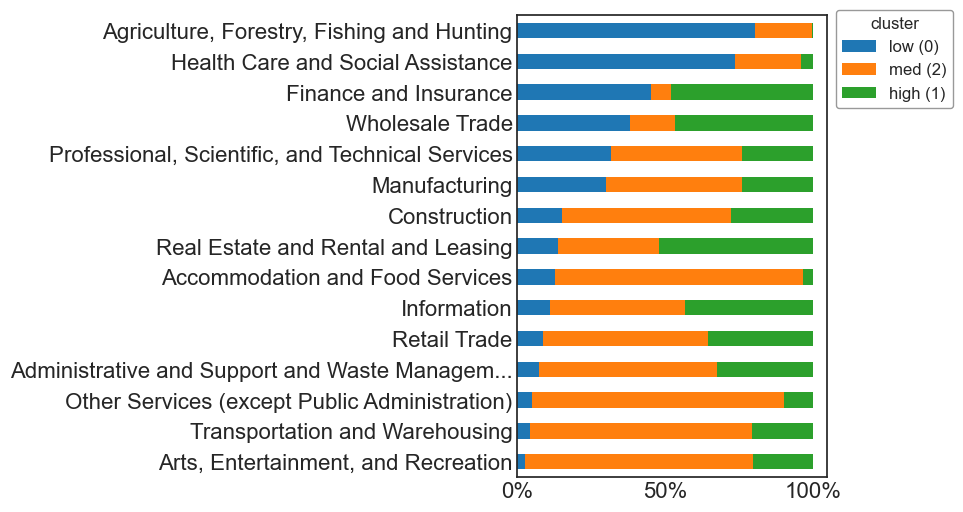

In [80]:
cluster_dist_sum = plot_fract_bar(cluster_sum_df,
                                 outfile= Path(setup.temp_path).joinpath('A12_PLOT_cluster_dist_loans.png'))
cluster_dist_sum.to_csv(Path(setup.temp_path).joinpath('A12_DATA_cluster_dist_loans.csv'), index=False)

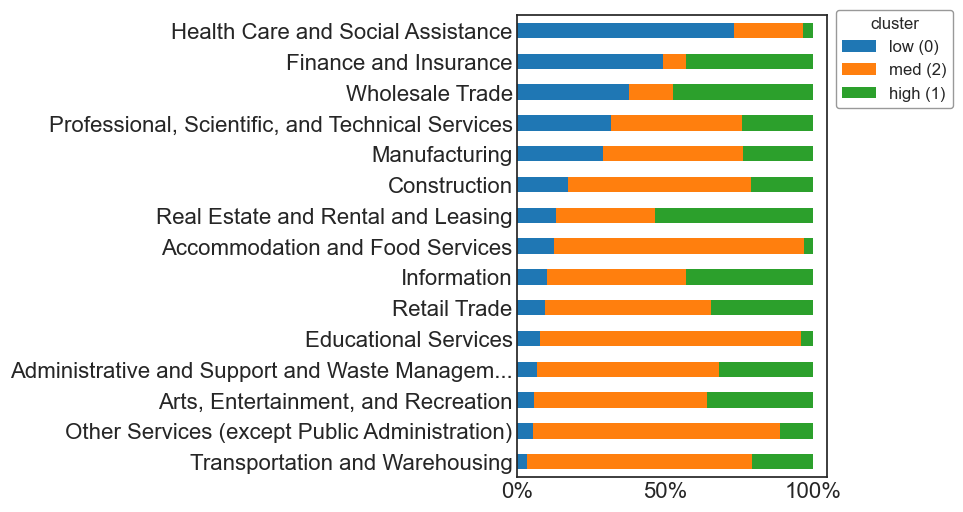

In [81]:
# Same plot, high-volume non holdout only
cluster_dist_sum = plot_fract_bar(cluster_sum_rept,
                                 outfile= Path(setup.temp_path).joinpath('A12_PLOT_cluster_dist_loans_filt.png'))
cluster_dist_sum.to_csv(Path(setup.temp_path).joinpath('A12_DATA_cluster_dist_loans_filt.csv'), index=False)

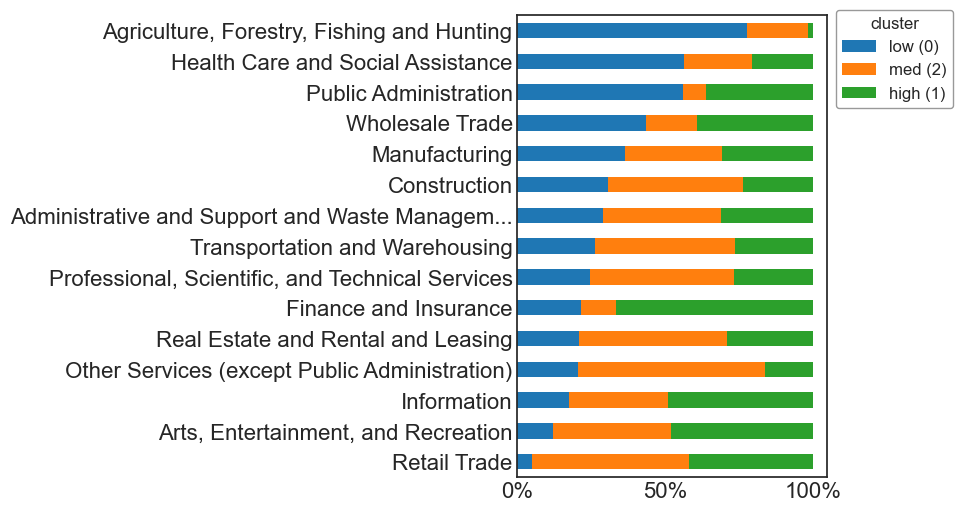

In [82]:
# Same plot, code count
cluster_dist_naics = plot_fract_bar(cluster_sum_df, agg_func='count',
                                 outfile= Path(setup.temp_path).joinpath('A12_PLOT_cluster_dist_naics_codes.png'))
cluster_dist_naics.to_csv(Path(setup.temp_path).joinpath('A12_DATA_cluster_dist_naics_codes.csv'), index=False)

Note publication https://www2.census.gov/library/publications/economic-census/2002/core-business-statistics-series/ec0200cbdg.pdf

## Look at low vs. high/med codes

In [84]:
cluster_sum_df['clus_2'] = np.where(cluster_sum_df['cluster_003'] == 0, 0, 1)
cluster_labels_2 = {0:'low risk', 1:'med/hi risk'}

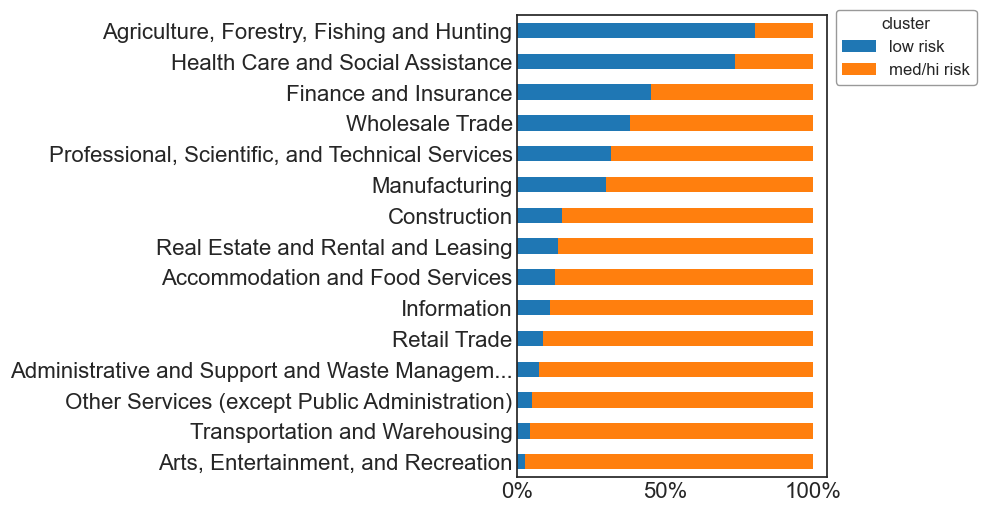

In [86]:
cluster_dist_sum = plot_fract_bar(cluster_sum_df,
                                  cluster_col = 'clus_2',
                       cluster_codes = cluster_labels_2,
                                 outfile= Path(setup.temp_path).joinpath('A12_PLOT_cluster_dist_loans_2grp.png'))
cluster_dist_sum.to_csv(Path(setup.temp_path).joinpath('A12_PLOT_cluster_dist_loans_2grp.csv'), index=False)